In [1]:
# Importing the most important modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
import time
from tqdm.notebook import tqdm

# Import plotly modules to view time series in a more interactive way
import plotly.graph_objects as go
import plotly.offline as pyo
from matplotlib.pyplot import cm
from IPython.display import Image

# Importing time series split for cross validation of time series models
from sklearn.model_selection import TimeSeriesSplit

# For Data Mining
import os, glob
from pandas import read_csv

# For Data Cleaning
from datetime import datetime
import missingno as msno

from matplotlib import pyplot
import matplotlib.dates as mdates

# Importing metrics to evaluate the implemented models
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Importing fbprophet for Prophet Model
from fbprophet import Prophet

In [2]:
# Setting the random seed for reproducability and several plotting style parameters
%matplotlib inline
plt.style.use('seaborn')
pyo.init_notebook_mode()
sns.set(rc={'figure.figsize':(14,8)})
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
RSEED = 42

## Time series

Analyzing Time series: 
The vaccination progress is reported daily, so that we have timeseries to analyze. 

In [3]:
#set DatetimeIndex as index for our DataFrame:
df_daily = pd.read_csv('df2.csv', index_col=None)
#df_daily = df_daily.set_index('date')
df_daily['date'] = pd.to_datetime(df_daily['date'])
df_daily.head(3)

country iso_code       date  total_vaccinations  people_vaccinated  \
0  Afghanistan      AFG 2021-02-23                 NaN                NaN   
1  Afghanistan      AFG 2021-02-24                 NaN                NaN   
2  Afghanistan      AFG 2021-02-25                 NaN                NaN   

   people_fully_vaccinated  daily_vaccinations  \
0                      0.0              1367.0   
1                      0.0              1367.0   
2                      0.0              1367.0   

   total_vaccinations_per_hundred  people_vaccinated_per_hundred  \
0                             NaN                            NaN   
1                             NaN                            NaN   
2                             NaN                            NaN   

   people_fully_vaccinated_per_hundred  daily_vaccinations_per_million  \
0                                  0.0                            35.0   
1                                  0.0                            35.0   
2                                  0.0                            35.0   

             vaccines  
0  Oxford/AstraZeneca  
1  Oxford/AstraZeneca  
2  Oxford/AstraZeneca

In [4]:
df_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7497 entries, 0 to 7496
Data columns (total 12 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   country                              7497 non-null   object        
 1   iso_code                             7497 non-null   object        
 2   date                                 7497 non-null   datetime64[ns]
 3   total_vaccinations                   4523 non-null   float64       
 4   people_vaccinated                    3983 non-null   float64       
 5   people_fully_vaccinated              7497 non-null   float64       
 6   daily_vaccinations                   7491 non-null   float64       
 7   total_vaccinations_per_hundred       4523 non-null   float64       
 8   people_vaccinated_per_hundred        3983 non-null   float64       
 9   people_fully_vaccinated_per_hundred  7497 non-null   float64       
 10  daily_vaccin

In [5]:
#df_daily.reset_index(inplace=True)

In [11]:
df_daily['day'] = df_daily['date'].dt.day
df_daily['month'] = df_daily['date'].dt.month
df_daily['year'] = df_daily['date'].dt.year
df_daily['weekday_name'] = df_daily['date'].dt.day_name()#day_of_week  
# Display a random sampling of 5 rows
df_daily.sample(5, random_state=0)

country iso_code       date  total_vaccinations  people_vaccinated  \
4512   Mauritius      MUS 2021-02-02                 NaN                NaN   
2412     Finland      FIN 2021-02-09            227427.0           173558.0   
4732    Mongolia      MNG 2021-03-11             48265.0                NaN   
4245  Luxembourg      LUX 2021-01-08                 NaN                NaN   
5700       Qatar      QAT 2021-03-11                 NaN                NaN   

      people_fully_vaccinated  daily_vaccinations  \
4512                      0.0                58.0   
2412                  53869.0              9065.0   
4732                      0.0              5009.0   
4245                      0.0                62.0   
5700                      0.0             15381.0   

      total_vaccinations_per_hundred  people_vaccinated_per_hundred  \
4512                             NaN                            NaN   
2412                            4.10                           3.13   
4732                            1.47                            NaN   
4245                             NaN                            NaN   
5700                             NaN                            NaN   

      people_fully_vaccinated_per_hundred  daily_vaccinations_per_million  \
4512                                 0.00                            46.0   
2412                                 0.97                          1636.0   
4732                                 0.00                          1528.0   
4245                                 0.00                            99.0   
5700                                 0.00                          5339.0   

                                          vaccines  day  month  year  \
4512                            Oxford/AstraZeneca    2      2  2021   
2412  Moderna, Oxford/AstraZeneca, Pfizer/BioNTech    9      2  2021   
4732                            Oxford/AstraZeneca   11      3  2021   
4245  Moderna, Oxford/AstraZeneca, Pfizer/BioNTech    8      1  2021   
5700                               Pfizer/BioNTech   11      3  2021   

     weekday_name  
4512      Tuesday  
2412      Tuesday  
4732     Thursday  
4245       Friday  
5700     Thursday

In [12]:
# Define plotting parameters and custom color palette 
cmaps_hex = ['#193251','#FF5A36','#1E4485', '#99D04A','#FF5A36', '#DB6668']
#sns.set_palette(palette=cmaps_hex)
sns_c = sns.color_palette(palette=cmaps_hex)

plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100

In [13]:
df_time = df_daily.copy()
df_time.set_index('date')
df_time = df_time[['date','country', 'daily_vaccinations', 'people_fully_vaccinated_per_hundred']]
df_time.sample(20)

date        country  daily_vaccinations  \
3940 2021-01-10         Kuwait              1121.0   
6439 2021-03-04       Slovakia             11936.0   
1159 2021-03-18       Bulgaria              4515.0   
3748 2021-02-03         Jersey               660.0   
5506 2021-02-23         Poland             92135.0   
6344 2021-02-15      Singapore             11964.0   
268  2021-01-10      Argentina             13365.0   
3310 2021-02-23      Indonesia             57394.0   
6159 2021-03-21        Senegal              3997.0   
350  2021-03-02      Australia              5575.0   
3031 2020-12-29        Hungary              1367.0   
6337 2021-02-08      Singapore              9889.0   
3082 2021-02-18        Hungary             16165.0   
5771 2021-02-23        Romania             34478.0   
401  2021-01-25        Austria             12202.0   
3110 2021-03-18        Hungary             48641.0   
1713 2021-03-09  Cote d'Ivoire               564.0   
4891 2021-02-08          Nepal             15179.0   
4170 2021-01-17      Lithuania              4095.0   
1512 2021-01-11          China            428571.0   

      people_fully_vaccinated_per_hundred  
3940                                 0.00  
6439                                 3.12  
1159                                 0.96  
3748                                 0.00  
5506                                 0.00  
6344                                 0.00  
268                                  0.00  
3310                                 0.29  
6159                                 0.00  
350                                  0.00  
3031                                 0.00  
6337                                 0.00  
3082                                 1.58  
5771                                 3.13  
401                                  0.05  
3110                                 4.60  
1713                                 0.00  
4891                                 0.00  
4170                                 0.04  
1512                                 0.00

In [14]:
#check for missing values
missing_values = pd.DataFrame(df_time.isnull().sum(), columns=['ID'])
missing_values

ID
date                                  0
country                               0
daily_vaccinations                    6
people_fully_vaccinated_per_hundred   0

In [15]:
df_time.dropna(axis=0)

date      country  daily_vaccinations  \
0    2021-02-23  Afghanistan              1367.0   
1    2021-02-24  Afghanistan              1367.0   
2    2021-02-25  Afghanistan              1367.0   
3    2021-02-26  Afghanistan              1367.0   
4    2021-02-27  Afghanistan              1367.0   
...         ...          ...                 ...   
7492 2021-03-20     Zimbabwe               836.0   
7493 2021-03-21     Zimbabwe               910.0   
7494 2021-03-22     Zimbabwe               805.0   
7495 2021-03-23     Zimbabwe               655.0   
7496 2021-03-24     Zimbabwe              1400.0   

      people_fully_vaccinated_per_hundred  
0                                     0.0  
1                                     0.0  
2                                     0.0  
3                                     0.0  
4                                     0.0  
...                                   ...  
7492                                  0.0  
7493                                  0.0  
7494                                  0.0  
7495                                  0.0  
7496                                  0.0  

[7491 rows x 4 columns]

In [16]:
#check for missing values
missing_values = pd.DataFrame(df_time.isnull().sum(), columns=['ID'])
missing_values

ID
date                                  0
country                               0
daily_vaccinations                    6
people_fully_vaccinated_per_hundred   0

In [17]:
df_time.isnull().any()

date                                   False
country                                False
daily_vaccinations                      True
people_fully_vaccinated_per_hundred    False
dtype: bool

In [18]:
df_time.dropna(inplace = True)

In [20]:
#check for missing values in %
round(100*(df_time.isnull().sum()/len(df_time.index)),0)

date                                   0.0
country                                0.0
daily_vaccinations                     0.0
people_fully_vaccinated_per_hundred    0.0
dtype: float64

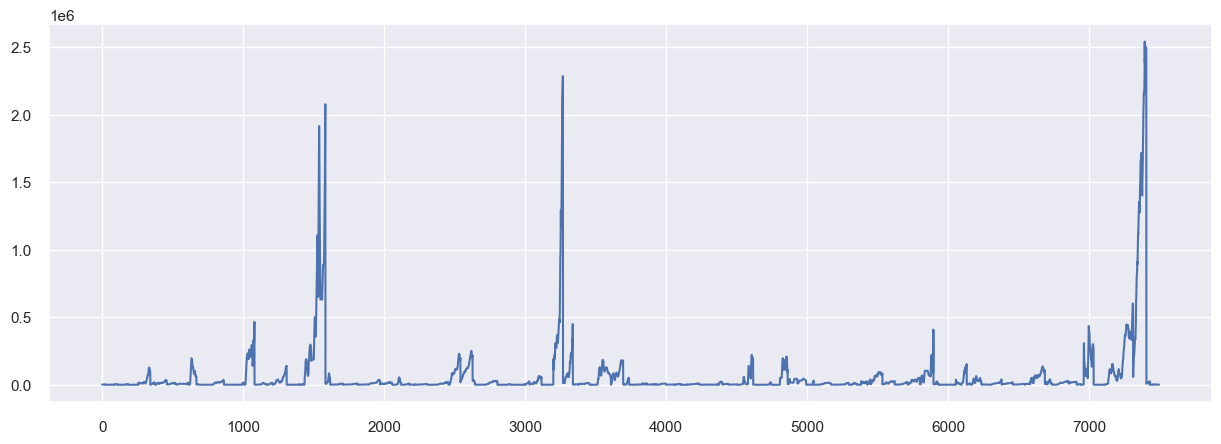

In [21]:
#nicht richtig , siehe Achsenwerte, Problem mehrere Werte pro Tag, da pro Land? plus Achsenbeschriftung
df_time["daily_vaccinations"].plot();

In [22]:
# Check decomposition of trend, seasonality and residue of original time series

decomposition = seasonal_decompose(x=df_time['daily_vaccinations'], period=10)# model='multiplicative',

fig, ax = plt.subplots(4, 1, figsize=(12, 12), constrained_layout=True)
decomposition.observed.plot(c=sns_c[0], ax=ax[0])
ax[0].set(title='daily_vaccinations')
decomposition.trend.plot(c=sns_c[1], ax=ax[1])
ax[1].set(title='trend')
decomposition.seasonal.plot(c=sns_c[2], ax=ax[2])
ax[2].set(title='seasonal')
decomposition.resid.plot(c=sns_c[3], ax=ax[3])
ax[3].set(title='residual')
fig.set_size_inches(20, 10);

NameError: name 'seasonal_decompose' is not defined

xxx

## Check for Stationarity

Stationarity: A time series is stationary if its statistical properties (e.g. mean, variance, etc.) are the same throughout the series, independently of the point in time where you observe it. There are no long-term predictable patterns such as trend or seasonality. Plots will show a roughly horizontal trend with constant variance.

noch umschreiben:

In order to check for stationarity we will apply three different methods. First, we will calculate and plot the rolling mean and rolling standard deviation. It they show an upward or downward trend or vary over time, then it is highly likely that our time series is non-stationary. Furthermore, we will use the ADF (Augmented Dickey-Fuller) and the KPSS (Kwiatkowski-Phillips-Schmidt-Shintests) tests. We have to be careful when interpreting the results: the null-hypothesis of the ADF test is that the time series is non-stationary whereas the KPSS test assumes that it is stationary.

In [ ]:
def stationarity_test(daily_vaccinations):
    
    # Calculate rolling mean and rolling standard deviation
    rolling_mean = daily_vaccinations.rolling(30).mean()
    rolling_std_dev = daily_vaccinations.rolling(30).std()
    
    # Plot the statistics
    plt.figure(figsize=(24,6))
    plt.plot(rolling_mean, color='#FF5A36', label='Rolling Mean')
    plt.plot(rolling_std_dev, color='#1E4485', label = 'Rolling Std Dev')
    plt.plot(daily_vaccinations, color='#99D04A',label='Original Time Series')
    plt.xticks([])
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    
    # ADF test
    print("ADF Test:")
    adf_test = adfuller(daily_vaccinations,autolag='AIC')
    print('Null Hypothesis: Not Stationary')
    print('ADF Statistic: %f' % adf_test[0])
    print('p-value: %f' % adf_test[1])
    print('----'*10)
    
    # KPSS test
    print("KPSS Test:")
    kpss_test = kpss(daily_vaccinations, regression='c', nlags="legacy", store=False)
    print('Null Hypothesis: Stationary')
    print('KPSS Statistic: %f' % kpss_test[0])
    print('p-value: %f' % kpss_test[1])
    print('----'*10)
    
stationarity_test(df_time['daily_vaccinations'])

The rolling mean moves up and down over time as as the daily vaccinations vary. The p-value of the ADF test is 0 which tells us that we can decline the null-hypothesis that the time series is non-stationary and the p-value for the KPSS test is over 0.05 which means we cannot reject this null-hypothesis that it is stationary. Both tests indicates that it is stationary.

In [ ]:
#check for stationarity for country data:
df_time_us = df_time[df_time.country == 'United States']
df_time_us

In [ ]:
#check for missing values in %
round(100*(df_time_us.isnull().sum()/len(df_time_us.index)),0)

In [ ]:

df_time_us["people_fully_vaccinated_per_hundred"].plot();

In [ ]:
def stationarity_test(daily_vaccinations):
    
    # Calculate rolling mean and rolling standard deviation
    rolling_mean = daily_vaccinations.rolling(30).mean()
    rolling_std_dev = daily_vaccinations.rolling(30).std()
    
    # Plot the statistics
    plt.figure(figsize=(24,6))
    plt.plot(rolling_mean, color='#FF5A36', label='Rolling Mean')
    plt.plot(rolling_std_dev, color='#1E4485', label = 'Rolling Std Dev')
    plt.plot(daily_vaccinations, color='#99D04A',label='Original Time Series')
    plt.xticks([])
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    
    # ADF test
    print("ADF Test:")
    adf_test = adfuller(daily_vaccinations,autolag='AIC')
    print('Null Hypothesis: Not Stationary')
    print('ADF Statistic: %f' % adf_test[0])
    print('p-value: %f' % adf_test[1])
    print('----'*10)
    
    # KPSS test
    print("KPSS Test:")
    kpss_test = kpss(daily_vaccinations, regression='c', nlags="legacy", store=False)
    print('Null Hypothesis: Stationary')
    print('KPSS Statistic: %f' % kpss_test[0])
    print('p-value: %f' % kpss_test[1])
    print('----'*10)
    
stationarity_test(df_time_us['daily_vaccinations'])

The p-value of the ADF test is > 0.5 which tells us that we cannot decline the null-hypothesis that the time series is non-stationary and the p-value for the KPSS test is below 0.05 which means we can reject this null-hypothesis that it is stationary. Both tests indicates that it is not stationary.

In [ ]:
# Check decomposition of trend, seasonality and residue of original time series

decomposition = seasonal_decompose(x=df_time_us['daily_vaccinations'], period=10)# model='multiplicative',

fig, ax = plt.subplots(4, 1, figsize=(12, 12), constrained_layout=True)
decomposition.observed.plot(c=sns_c[0], ax=ax[0])
ax[0].set(title='daily_vaccinations')
decomposition.trend.plot(c=sns_c[1], ax=ax[1])
ax[1].set(title='trend')
decomposition.seasonal.plot(c=sns_c[2], ax=ax[2])
ax[2].set(title='seasonal')
decomposition.resid.plot(c=sns_c[3], ax=ax[3])
ax[3].set(title='residual')
fig.set_size_inches(20, 10);

In [ ]:
# Check decomposition of trend, seasonality and residue of original time series

decomposition = seasonal_decompose(x=df_time_us['people_fully_vaccinated_per_hundred'], period=10)# model='multiplicative',

fig, ax = plt.subplots(4, 1, figsize=(12, 12), constrained_layout=True)
decomposition.observed.plot(c=sns_c[0], ax=ax[0])
ax[0].set(title='daily_vaccinations')
decomposition.trend.plot(c=sns_c[1], ax=ax[1])
ax[1].set(title='trend')
decomposition.seasonal.plot(c=sns_c[2], ax=ax[2])
ax[2].set(title='seasonal')
decomposition.resid.plot(c=sns_c[3], ax=ax[3])
ax[3].set(title='residual')
fig.set_size_inches(20, 10);

## De-trend the Time Series 

In [ ]:
# De-trending the time series
df_time_us['dayvacc_Detrend'] = (df_time_us['daily_vaccinations'] - df_time_us['daily_vaccinations'].shift(30))

In [ ]:
# Test for stationarity after de-trending 
def stationarity_test(daily_vaccinations):
    
    # Calculate rolling mean and rolling standard deviation
    rolling_mean = daily_vaccinations.rolling(30).mean()
    rolling_std_dev = daily_vaccinations.rolling(30).std()
    
    # Plot the statistics
    plt.figure(figsize=(24,6))
    plt.plot(rolling_mean, color='#FF5A36', label='Rolling Mean')
    plt.plot(rolling_std_dev, color='#1E4485', label = 'Rolling Std Dev')
    plt.plot(daily_vaccinations, color='#99D04A',label='Original Time Series')
    plt.xticks([])
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    
    # ADF test
    print("ADF Test:")
    adf_test = adfuller(daily_vaccinations,autolag='AIC')
    print('Null Hypothesis: Not Stationary')
    print('ADF Statistic: %f' % adf_test[0])
    print('p-value: %f' % adf_test[1])
    print('----'*10)
    
    # KPSS test
    print("KPSS Test:")
    kpss_test = kpss(daily_vaccinations, regression='c', nlags='legacy', store=False)
    print('Null Hypothesis: Stationary')
    print('KPSS Statistic: %f' % kpss_test[0])
    print('p-value: %f' % kpss_test[1])
    print('----'*10)
    
stationarity_test(df_time_us['dayvacc_Detrend'].dropna())

# Partial Autocorrelation Plot
pacf = plot_pacf(df_time_us['dayvacc_Detrend'].dropna(), lags=30)

In [ ]:
# sum up all vaccinations values per day for getting a global value
df_time_index = df_time[['date', 'daily_vaccinations', 'people_fully_vaccinated_per_hundred']]
df_time_index['date'] = pd.to_datetime(df_time_index.date)

df_time_index.set_index('date', inplace=True)
df_time_index.index.get_level_values('date').floor('D')
df_time_index = df_time_index.groupby('date').sum().reset_index()
df_time_index.to_csv('dates_aggregated.csv', encoding='utf-8', index=True)

In [ ]:
df_time_index

In [ ]:
df_time.to_csv('timeseriesformodel.csv', encoding='utf-8', index=False)

In [ ]:
df1_corr.head()

In [ ]:
df_time = df1_corr.copy()
df_time.set_index('date')
df_time = df_time[['date','country', 'daily_vaccinations', 'people_fully_vaccinated_per_hundred']]
df_time.sample(20)

In [ ]:
#check for missing values
missing_values = pd.DataFrame(df_time.isnull().sum(), columns=['ID'])
missing_values

In [ ]:
df_time.dropna(axis=0)

In [ ]:
#check for missing values
missing_values = pd.DataFrame(df_time.isnull().sum(), columns=['ID'])
missing_values

In [ ]:
df_time.isnull().any()

In [ ]:
df_time.dropna(inplace = True)

In [ ]:
#check for missing values in %
round(100*(df1_corr.isnull().sum()/len(df1_corr.index)),0)

In [ ]:
#nicht richtig , siehe Achsenwerte, Problem mehrere Werte pro Tag, da pro Land?
df_time["daily_vaccinations"].plot();

In [ ]:
# Check decomposition of trend, seasonality and residue of original time series

decomposition = seasonal_decompose(x=df_time['daily_vaccinations'], period=10)# model='multiplicative',

fig, ax = plt.subplots(4, 1, figsize=(12, 12), constrained_layout=True)
decomposition.observed.plot(c=sns_c[0], ax=ax[0])
ax[0].set(title='daily_vaccinations')
decomposition.trend.plot(c=sns_c[1], ax=ax[1])
ax[1].set(title='trend')
decomposition.seasonal.plot(c=sns_c[2], ax=ax[2])
ax[2].set(title='seasonal')
decomposition.resid.plot(c=sns_c[3], ax=ax[3])
ax[3].set(title='residual')
fig.set_size_inches(20, 10);

xxx

## Check for Stationarity

Stationarity: A time series is stationary if its statistical properties (e.g. mean, variance, etc.) are the same throughout the series, independently of the point in time where you observe it. There are no long-term predictable patterns such as trend or seasonality. Plots will show a roughly horizontal trend with constant variance.

noch umschreiben:

In order to check for stationarity we will apply three different methods. First, we will calculate and plot the rolling mean and rolling standard deviation. It they show an upward or downward trend or vary over time, then it is highly likely that our time series is non-stationary. Furthermore, we will use the ADF (Augmented Dickey-Fuller) and the KPSS (Kwiatkowski-Phillips-Schmidt-Shintests) tests. We have to be careful when interpreting the results: the null-hypothesis of the ADF test is that the time series is non-stationary whereas the KPSS test assumes that it is stationary.

In [ ]:
def stationarity_test(daily_vaccinations):
    
    # Calculate rolling mean and rolling standard deviation
    rolling_mean = daily_vaccinations.rolling(30).mean()
    rolling_std_dev = daily_vaccinations.rolling(30).std()
    
    # Plot the statistics
    plt.figure(figsize=(24,6))
    plt.plot(rolling_mean, color='#FF5A36', label='Rolling Mean')
    plt.plot(rolling_std_dev, color='#1E4485', label = 'Rolling Std Dev')
    plt.plot(daily_vaccinations, color='#99D04A',label='Original Time Series')
    plt.xticks([])
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    
    # ADF test
    print("ADF Test:")
    adf_test = adfuller(daily_vaccinations,autolag='AIC')
    print('Null Hypothesis: Not Stationary')
    print('ADF Statistic: %f' % adf_test[0])
    print('p-value: %f' % adf_test[1])
    print('----'*10)
    
    # KPSS test
    print("KPSS Test:")
    kpss_test = kpss(daily_vaccinations, regression='c', nlags="legacy", store=False)
    print('Null Hypothesis: Stationary')
    print('KPSS Statistic: %f' % kpss_test[0])
    print('p-value: %f' % kpss_test[1])
    print('----'*10)
    
stationarity_test(df_time['daily_vaccinations'])

The rolling mean moves up and down over time as as the daily vaccinations vary. The p-value of the ADF test is 0 which tells us that we can decline the null-hypothesis that the time series is non-stationary and the p-value for the KPSS test is over 0.05 which means we cannot reject this null-hypothesis that it is stationary. Both tests indicates that it is stationary.

In [ ]:
#check for stationarity for country data:
df_time_us = df_time[df_time.country == 'United States']
df_time_us

In [ ]:
#check for missing values in %
round(100*(df_time_us.isnull().sum()/len(df_time_us.index)),0)

In [ ]:

df_time_us["people_fully_vaccinated_per_hundred"].plot();

In [ ]:
# sum up all vaccinations values per day for getting a global value
df_time_index = df_time[['date', 'daily_vaccinations', 'people_fully_vaccinated_per_hundred']]
df_time_index['date'] = pd.to_datetime(df_time_index.date)

df_time_index.set_index('date', inplace=True)
df_time_index.index.get_level_values('date').floor('D')
df_time_index = df_time_index.groupby('date').sum().reset_index()
df_time_index.to_csv('dates_aggregated.csv', encoding='utf-8', index=True)

In [ ]:
df_time_index

In [ ]:
df_time.to_csv('timeseriesformodel.csv', encoding='utf-8', index=False)

Load data

In [23]:
# load cleaned data time series with aggregated daily vaccinations per day to show global values:
df_time_m_agg = pd.read_csv('dates_aggregated.csv')
df_time_m_agg.head()

Unnamed: 0        date  daily_vaccinations  \
0           0  2020-12-14            168234.0   
1           1  2020-12-15            168952.0   
2           2  2020-12-16            360600.0   
3           3  2020-12-17            361490.0   
4           4  2020-12-18            361883.0   

   people_fully_vaccinated_per_hundred  
0                                  0.0  
1                                  0.0  
2                                  0.0  
3                                  0.0  
4                                  0.0

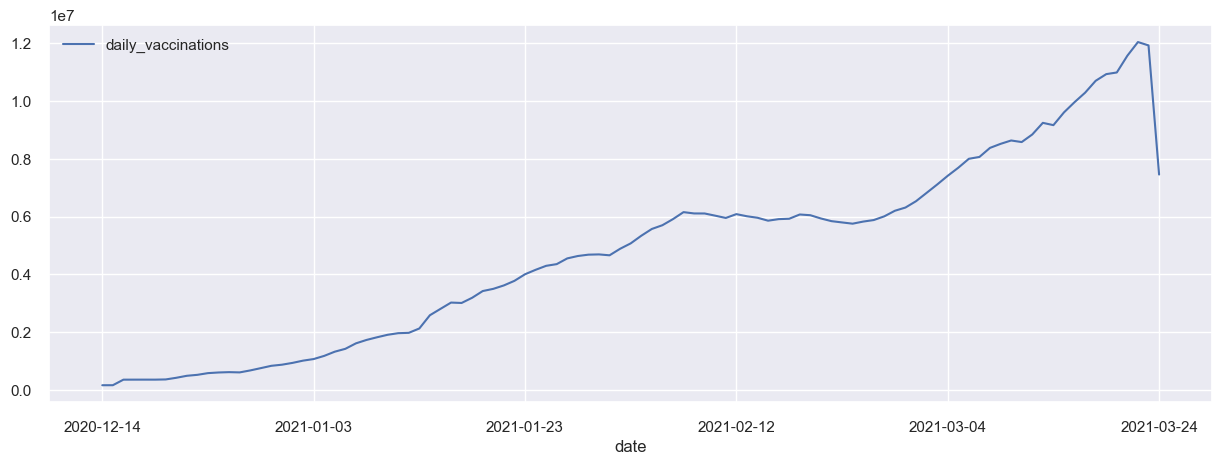

In [24]:
# plot the time series for global vaccinations per day:
df_time_m_agg1 = df_time_m_agg[['date','daily_vaccinations']]
df_time_m_agg1.set_index('date', inplace=True)
df_time_m_agg1.plot()
pyplot.show()

In [25]:
#train - test - split

df_time_m_agg2 = df_time_m_agg1
df_time_m_agg2.reset_index(inplace=True)
df_time_m_agg2['cap']= 7790000000
train_test_split_ratio = int(len(df_time_m_agg2)*0.8)
train_data, test_data = df_time_m_agg2[:train_test_split_ratio], df_time_m_agg2[train_test_split_ratio:]

train_data

date  daily_vaccinations         cap
0   2020-12-14            168234.0  7790000000
1   2020-12-15            168952.0  7790000000
2   2020-12-16            360600.0  7790000000
3   2020-12-17            361490.0  7790000000
4   2020-12-18            361883.0  7790000000
..         ...                 ...         ...
75  2021-02-27           6202951.0  7790000000
76  2021-02-28           6314410.0  7790000000
77  2021-03-01           6533556.0  7790000000
78  2021-03-02           6821542.0  7790000000
79  2021-03-03           7110472.0  7790000000

[80 rows x 3 columns]

In [26]:
# prepare expected column names
train_data.columns = ['ds', 'y', 'cap']
train_data['ds']= pd.to_datetime(train_data['ds'])
# define the model
model = Prophet(growth = 'logistic')
# fit the model
model.fit(train_data)
print(train_data.tail())

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           ds          y         cap
75 2021-02-27  6202951.0  7790000000
76 2021-02-28  6314410.0  7790000000
77 2021-03-01  6533556.0  7790000000
78 2021-03-02  6821542.0  7790000000
79 2021-03-03  7110472.0  7790000000


In [27]:
future = model.make_future_dataframe(periods=365)
future['cap']= 7790000000
future.tail()

ds         cap
440 2022-02-27  7790000000
441 2022-02-28  7790000000
442 2022-03-01  7790000000
443 2022-03-02  7790000000
444 2022-03-03  7790000000

In [28]:
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds          yhat    yhat_lower    yhat_upper
440 2022-02-27  3.798745e+07  -3393.282210  7.342785e+09
441 2022-02-28  3.816049e+07 -43442.893111  7.363833e+09
442 2022-03-01  3.836541e+07  14718.876312  7.382612e+09
443 2022-03-02  3.859404e+07  49011.182317  7.404491e+09
444 2022-03-03  3.876086e+07  34981.891539  7.423381e+09

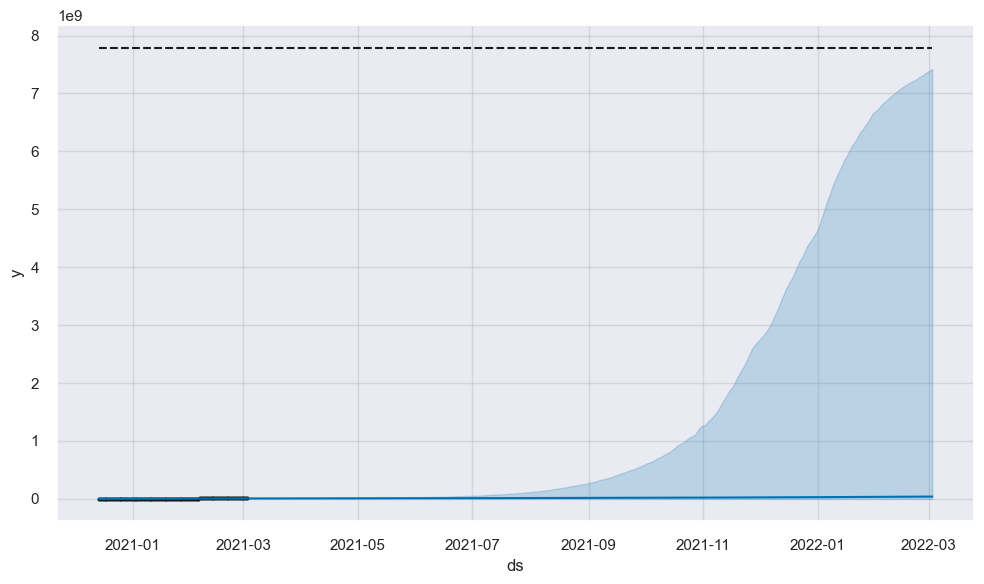

In [29]:
fig1 = model.plot(forecast)

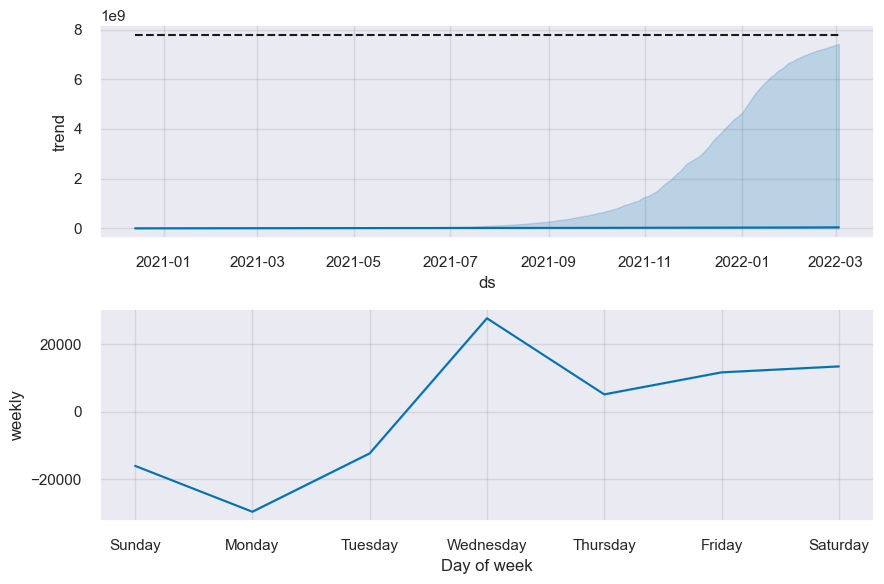

In [30]:
fig2 = model.plot_components(forecast)

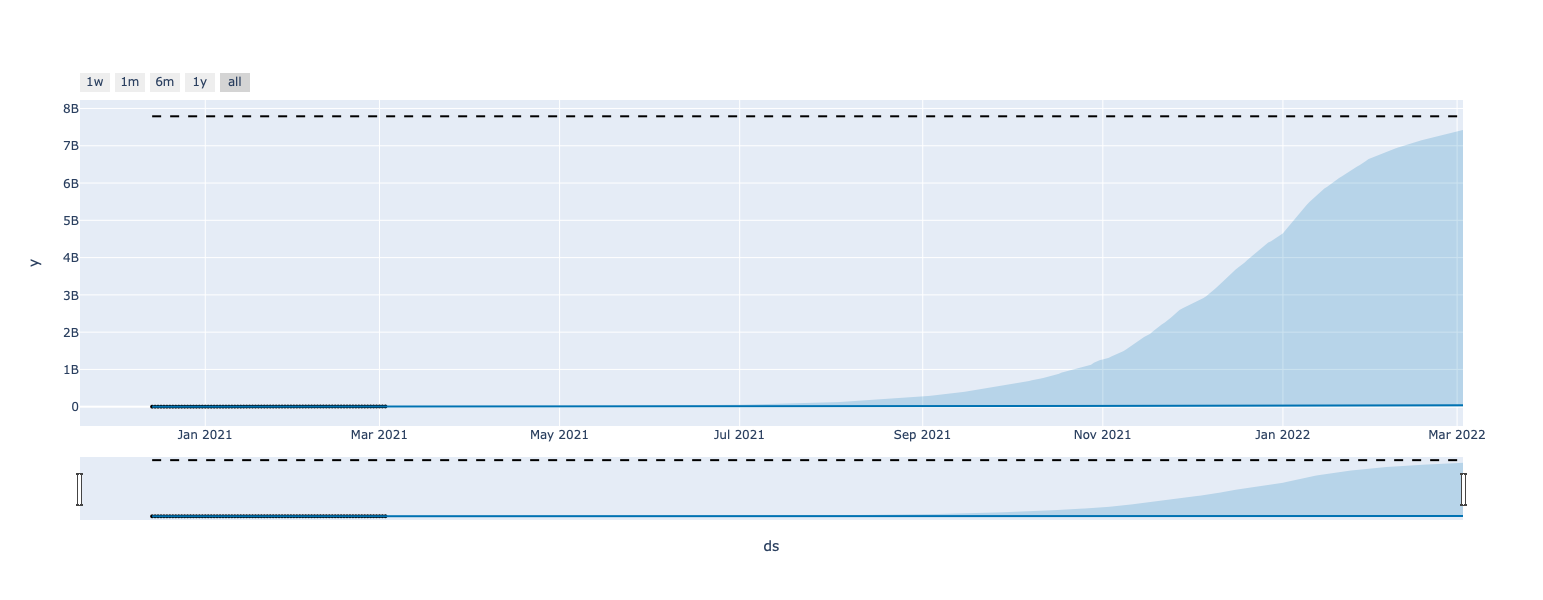

In [31]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(model, forecast)

In [32]:
# load cleaned data time series:
df_time_m = pd.read_csv('df_for_model.csv')
#df_time_m = df_time_m[['date','daily_vaccinations', 'country', 'people_fully_vaccinated_per_hundred']]
#df_time_m
# plot the time series
#df_time_m.plot()
#pyplot.show()

In [33]:
#df_time_m.sample(15)

In [34]:
#erste Versuche

In [35]:
df_time_m_us = df_time_m[df_time_m.country == 'United States']
df_time_m_us1 = df_time_m_us[['date','people_vaccinated_per_hundred']]#,'daily_vaccinations', 
#train - test - split

df_time_m_us2 = df_time_m_us1
df_time_m_us2['cap']= 328000000
train_test_split_ratio = int(len(df_time_m_us2)*0.8)
train_data, test_data = df_time_m_us2[:train_test_split_ratio], df_time_m_us2[train_test_split_ratio:]



In [36]:
df_time_m_us2.tail()

date  people_vaccinated_per_hundred        cap
6599  2021-03-19                          23.09  328000000
6600  2021-03-20                          23.73  328000000
6601  2021-03-21                          24.34  328000000
6602  2021-03-22                          24.75  328000000
6603  2021-03-23                          25.10  328000000

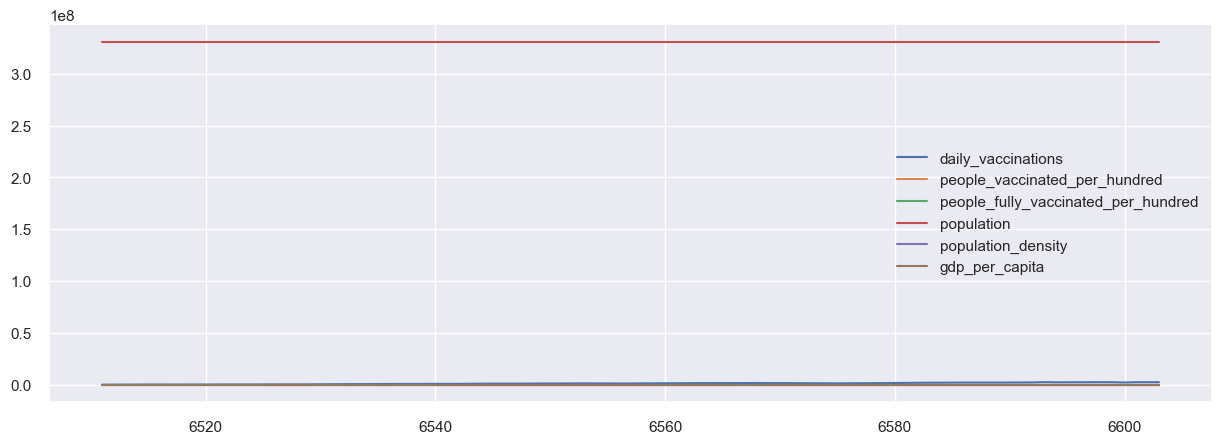

In [37]:
df_time_m_us.plot()
pyplot.show()

In [38]:
# prepare expected column names
train_data.columns = ['ds', 'y', 'cap']
train_data['ds']= pd.to_datetime(train_data['ds'])
# define the model
model = Prophet(growth = 'logistic')
# fit the model
model.fit(train_data)
print(train_data.tail())

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds      y        cap
6580 2021-02-28  14.88  328000000
6581 2021-03-01  15.17  328000000
6582 2021-03-02  15.48  328000000
6583 2021-03-03  15.80  328000000
6584 2021-03-04  16.16  328000000


In [39]:
future = model.make_future_dataframe(periods=71)
future['cap']= 3280000
future.tail()

ds      cap
140 2021-05-10  3280000
141 2021-05-11  3280000
142 2021-05-12  3280000
143 2021-05-13  3280000
144 2021-05-14  3280000

In [40]:
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds      yhat  yhat_lower  yhat_upper
140 2021-05-10  0.579778    0.262433    1.102002
141 2021-05-11  0.630985    0.302859    1.160458
142 2021-05-12  0.530295    0.179563    1.106905
143 2021-05-13  0.598732    0.255474    1.206832
144 2021-05-14  0.646966    0.298703    1.271769

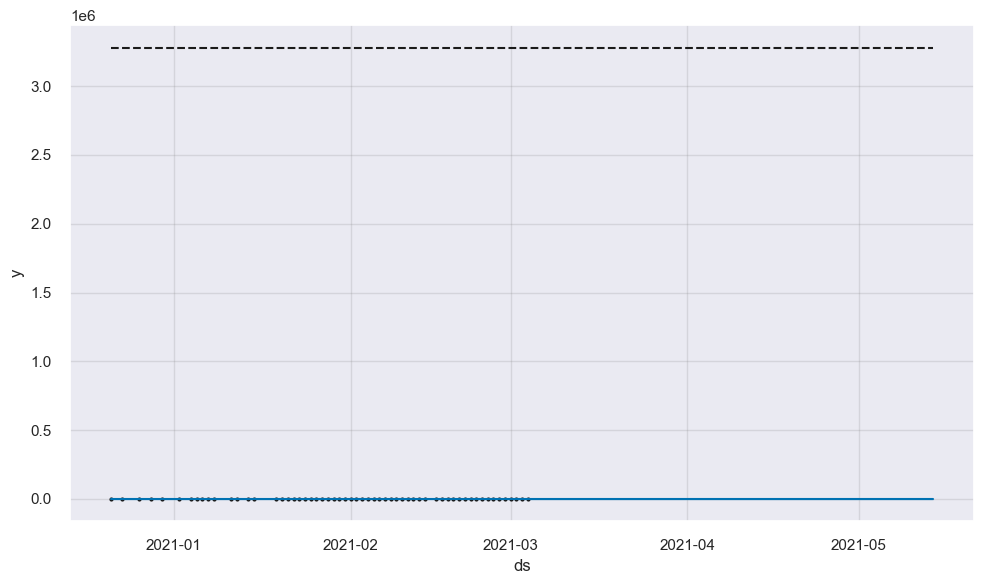

In [41]:
fig1 = model.plot(forecast)

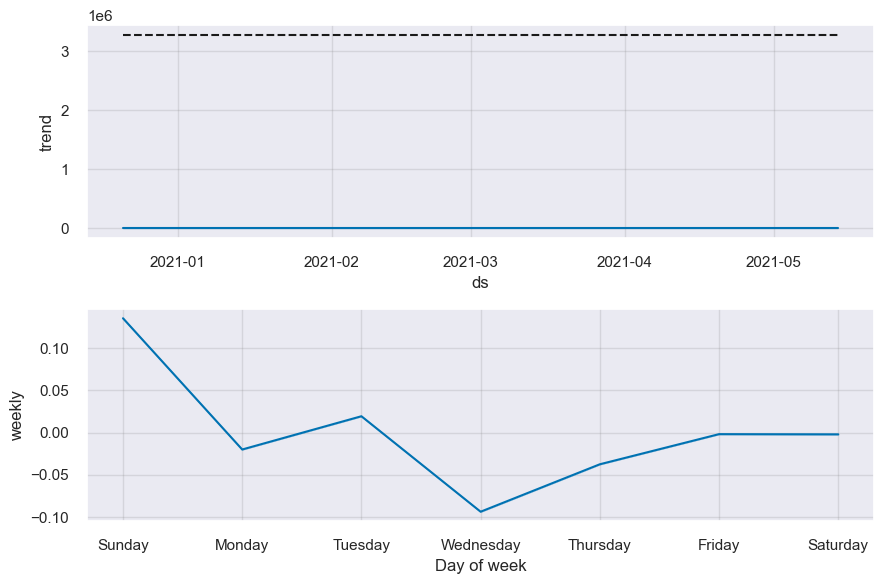

In [42]:
fig2 = model.plot_components(forecast)

In [43]:
#!install jupyterlab-plotly@4.14.3
#%jupyter labextension install jupyterlab-plotly@4.14.3

UsageError: Line magic function `%jupyter` not found.


In [ ]:
#%jupyter labextension install @jupyter-widgets/jupyterlab-manager plotlywidget@4.14.3

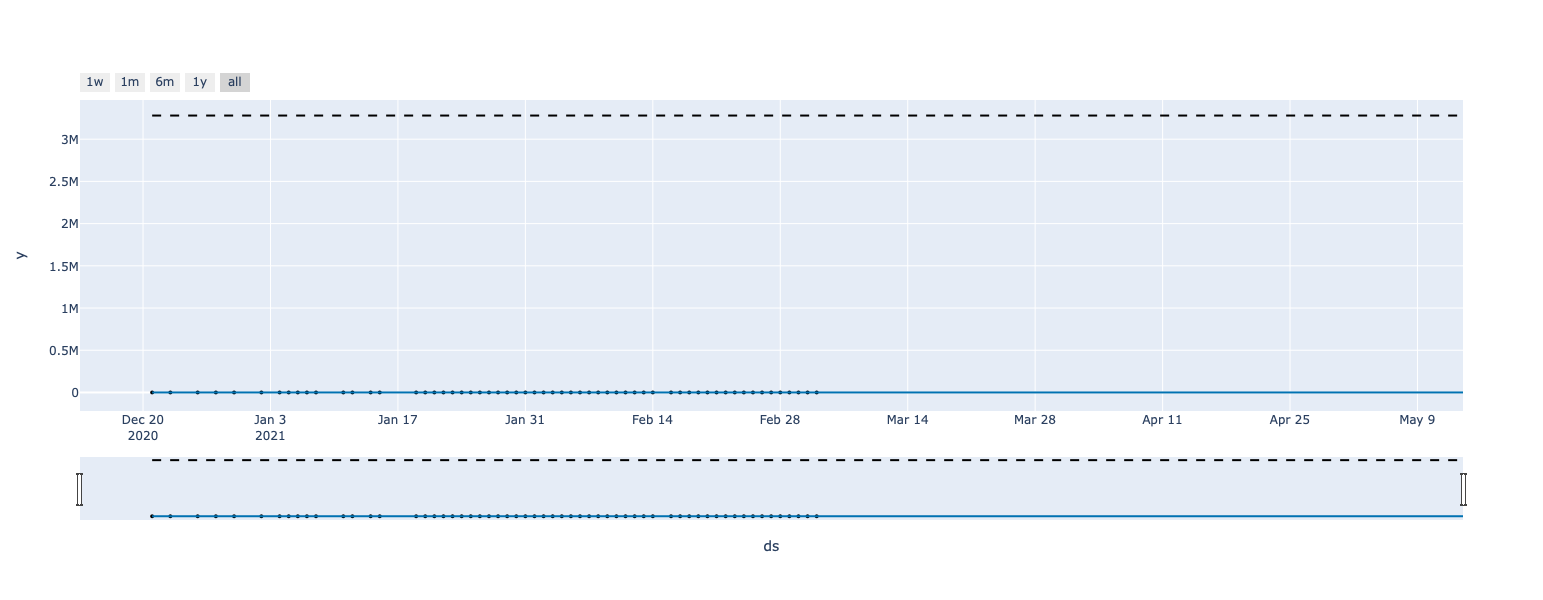

In [44]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(model, forecast)

## Prediction for Germany

In [45]:
df_time_m_ger = df_time_m[df_time_m.country == 'Germany']
df_time_m_ger1 = df_time_m_ger[['date','daily_vaccinations']]
#train - test - split
df_time_m_ger2 = df_time_m_ger1
train_test_split_ratio = int(len(df_time_m_ger2)*0.8)
train_data, test_data = df_time_m_ger2[:train_test_split_ratio], df_time_m_ger2[train_test_split_ratio:]



In [46]:
# prepare expected column names
train_data.columns = ['ds', 'y']
train_data['ds']= pd.to_datetime(train_data['ds'])
# define the model
model = Prophet()
# fit the model
model.fit(train_data)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [47]:
future = model.make_future_dataframe(periods=365)
future['cap']= 80000000
future.tail()

ds       cap
428 2022-03-01  80000000
429 2022-03-02  80000000
430 2022-03-03  80000000
431 2022-03-04  80000000
432 2022-03-05  80000000

In [48]:
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds          yhat    yhat_lower    yhat_upper
428 2022-03-01  1.623271e+06  1.000210e+06  2.274133e+06
429 2022-03-02  1.628458e+06  1.002501e+06  2.284739e+06
430 2022-03-03  1.632966e+06  1.003859e+06  2.286826e+06
431 2022-03-04  1.637568e+06  1.010075e+06  2.293933e+06
432 2022-03-05  1.639399e+06  1.006083e+06  2.301006e+06

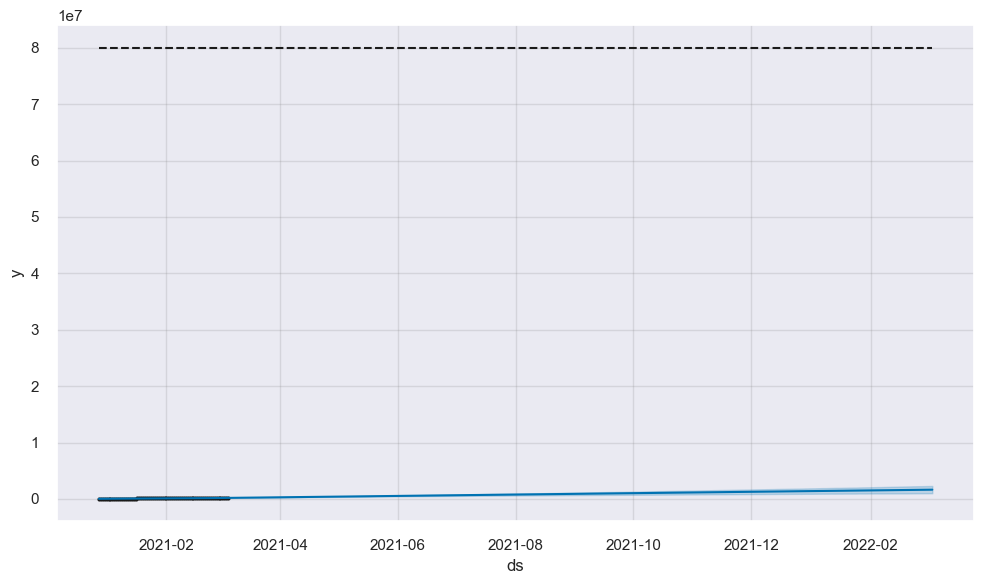

In [49]:
fig1 = model.plot(forecast)

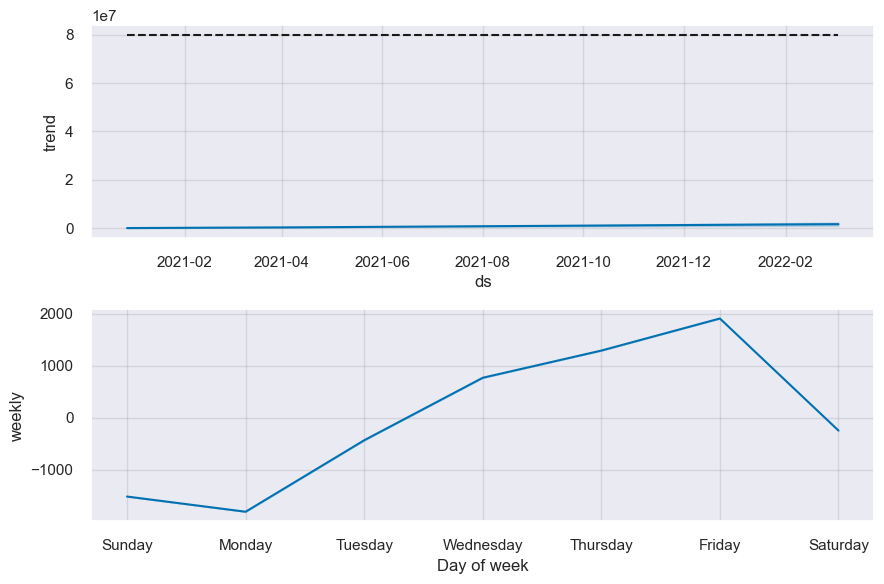

In [50]:
fig2 = model.plot_components(forecast)

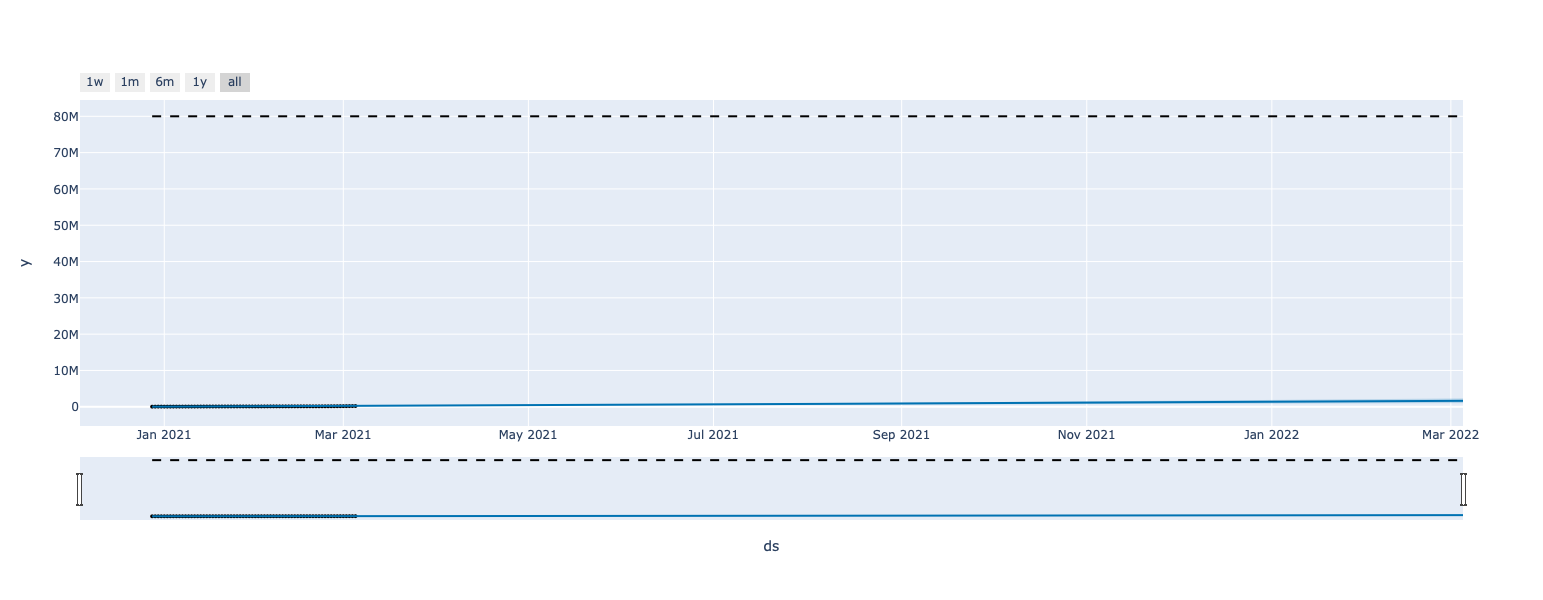

In [51]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(model, forecast)

In [52]:
#for other countries:

In [53]:
top_10_vacc = list(df_time_m[(~df_time_m['people_fully_vaccinated_per_hundred'].isna())&(df_time_m['date']=='2021-03-28')].sort_values(by='people_fully_vaccinated_per_hundred',ascending=False).head(10)['country'])

In [54]:
top_10_vacc

[]

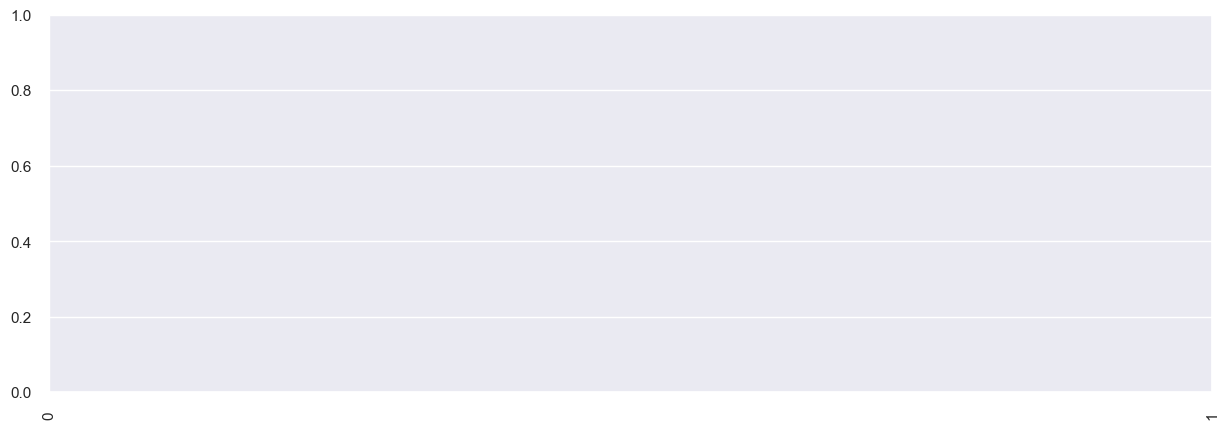

In [55]:
#Top 10 GDP countries in the world vaccination rates
graph = sns.lineplot(data=df_time_m[df_time_m['country'].isin(top_10_vacc)]
                     .sort_values(by="date"), x="date", y="people_fully_vaccinated_per_hundred",hue='country')
graph.xaxis.set_major_locator(mdates.DayLocator(interval = 7))
# graph.xaxis.set_major_formatter(mdates.DateFormatter('%Y:%M:%D'))
plt.xticks(rotation = 90)

plt.show()

In [56]:
#from fbprophet import Prophet
def fcast(cntry):
    p = df_time_m[df_time_m['country'].isin([cntry])].sort_values(by="date")[['date',"people_fully_vaccinated_per_hundred"]]
    p.columns = ['ds', 'y']
    # define the model
    model = Prophet()
    # # fit the model
    model.fit(p)
    # define the period for which we want a prediction
    future = list()
    for i in range(1, 13):
        date = '2021-%02d' % i
        future.append([date])
    for i in range(1, 13):
        date = '2022-%02d' % i
        future.append([date])    
    future = pd.DataFrame(future)
    future.columns = ['ds']
    future['ds']= pd.to_datetime(future['ds'])
    
    # use the model to make a forecast
    forecast = model.predict(future)
    # summarize the forecast
    print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head(10))
    # plot forecast
    model.plot(forecast)
    plt.ylim(0, 100)
    n_lower=forecast['yhat_lower'].sub(100).abs().idxmin()
    n_upper=forecast['yhat_upper'].sub(100).abs().idxmin()
    plt.title(cntry 
              + ' forecast of people_fully_vaccinated_per_hundred: 100% expected between ' 
              + forecast[n_upper:n_upper+1]['ds'].iloc[0].strftime('%Y-%m-%d') 
              + ' and ' 
              + forecast[n_lower:n_lower+1]['ds'].iloc[0].strftime('%Y-%m-%d'))
    plt.show()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


          ds        yhat  yhat_lower  yhat_upper
0 2021-01-01    0.079691   -0.202369    0.367618
1 2021-02-01   21.664094   21.352859   21.953673
2 2021-03-01   40.124951   39.843348   40.402695
3 2021-04-01   60.517517   59.332133   61.990535
4 2021-05-01   79.284050   68.309564   92.290660
5 2021-06-01   99.408272   70.708836  131.507463
6 2021-07-01  119.072627   70.878050  175.835555
7 2021-08-01  138.549725   63.765096  220.722175
8 2021-09-01  158.792849   58.984625  275.901085
9 2021-10-01  178.061082   48.955636  330.487128


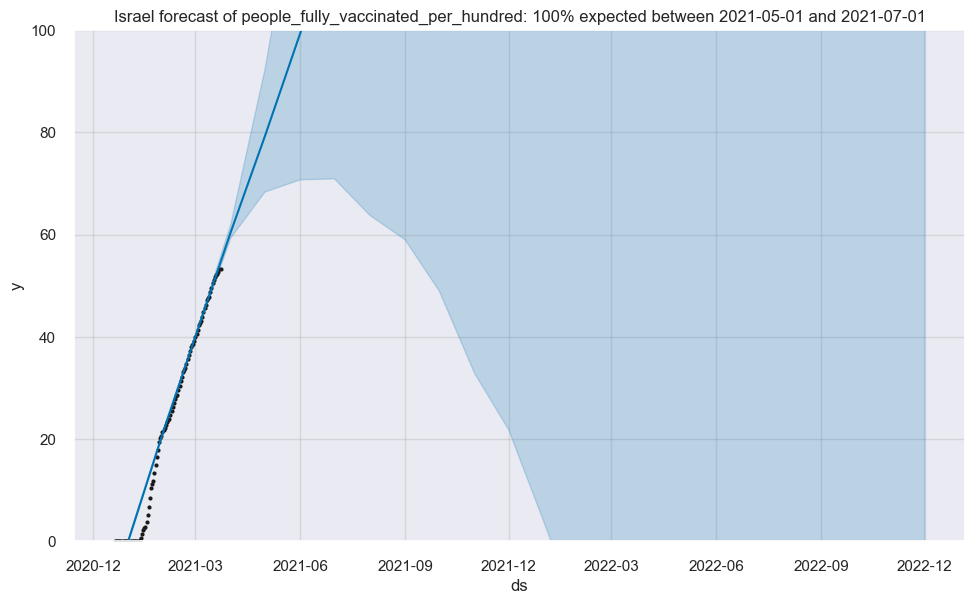

In [57]:
fcast('Israel')

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


          ds       yhat  yhat_lower  yhat_upper
0 2021-01-01   0.051195   -0.450463    0.577987
1 2021-02-01   1.535092    1.036864    2.065579
2 2021-03-01   7.317996    6.757447    7.807912
3 2021-04-01  16.008252   15.502409   16.576605
4 2021-05-01  24.172507   22.798820   25.550226
5 2021-06-01  32.514139   29.434250   35.951173
6 2021-07-01  40.644755   35.360387   46.100272
7 2021-08-01  49.089623   41.171863   57.359062
8 2021-09-01  57.396622   46.687284   68.655318
9 2021-10-01  65.578163   51.871591   80.355003


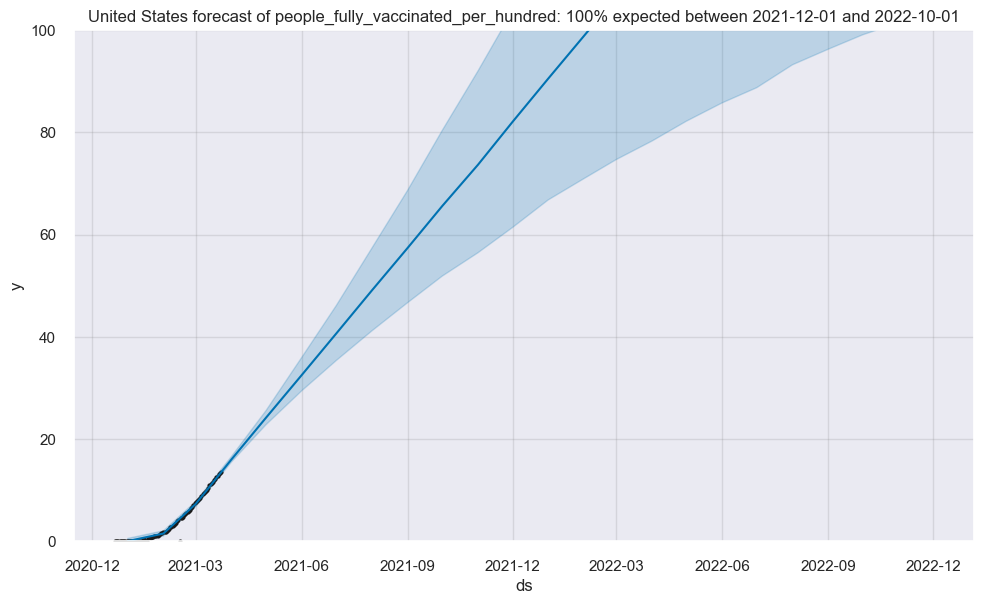

In [58]:
fcast('United States')

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


          ds       yhat  yhat_lower  yhat_upper
0 2021-01-01   0.018316    0.002378    0.034728
1 2021-02-01   0.783717    0.767057    0.800613
2 2021-03-01   2.612111    2.594747    2.628254
3 2021-04-01   4.821964    4.759084    4.880148
4 2021-05-01   6.991991    6.428422    7.548661
5 2021-06-01   9.217154    7.823121   10.597131
6 2021-07-01  11.404650    9.031267   13.744965
7 2021-08-01  13.624879   10.140575   17.156711
8 2021-09-01  15.881848   11.053567   20.654967
9 2021-10-01  18.068530   11.676651   24.250820


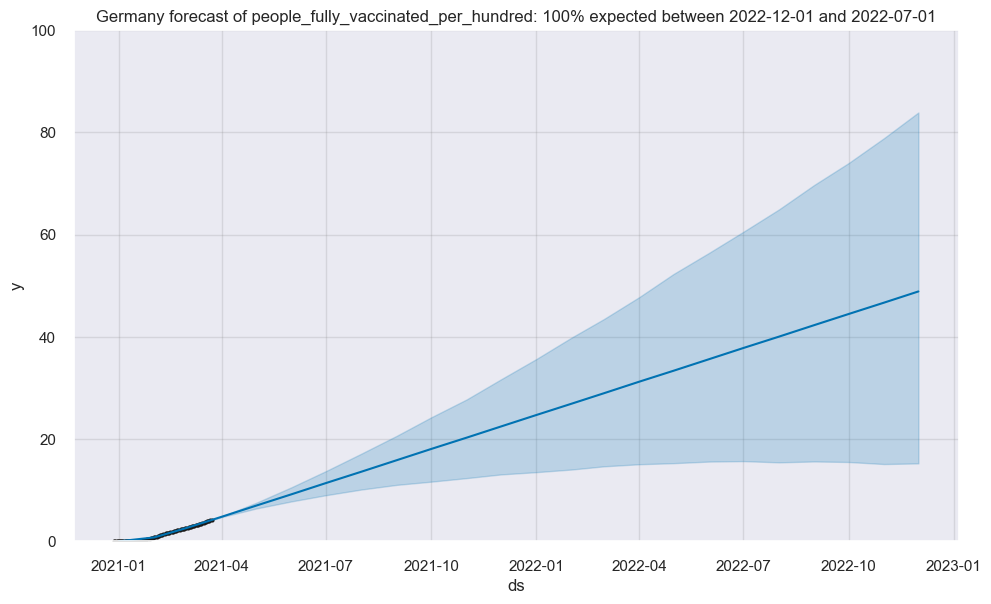

In [59]:
fcast('Germany')

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


          ds      yhat  yhat_lower  yhat_upper
0 2021-01-01  0.003446   -0.002740    0.009716
1 2021-02-01 -0.001500   -0.007570    0.004609
2 2021-03-01  0.188508    0.182717    0.194845
3 2021-04-01  0.766714    0.753781    0.780591
4 2021-05-01  1.365743    1.248675    1.491069
5 2021-06-01  1.977195    1.709601    2.280308
6 2021-07-01  2.569279    2.107013    3.089278
7 2021-08-01  3.181440    2.442768    3.966159
8 2021-09-01  3.797406    2.803520    4.901828
9 2021-10-01  4.396088    3.085579    5.798228


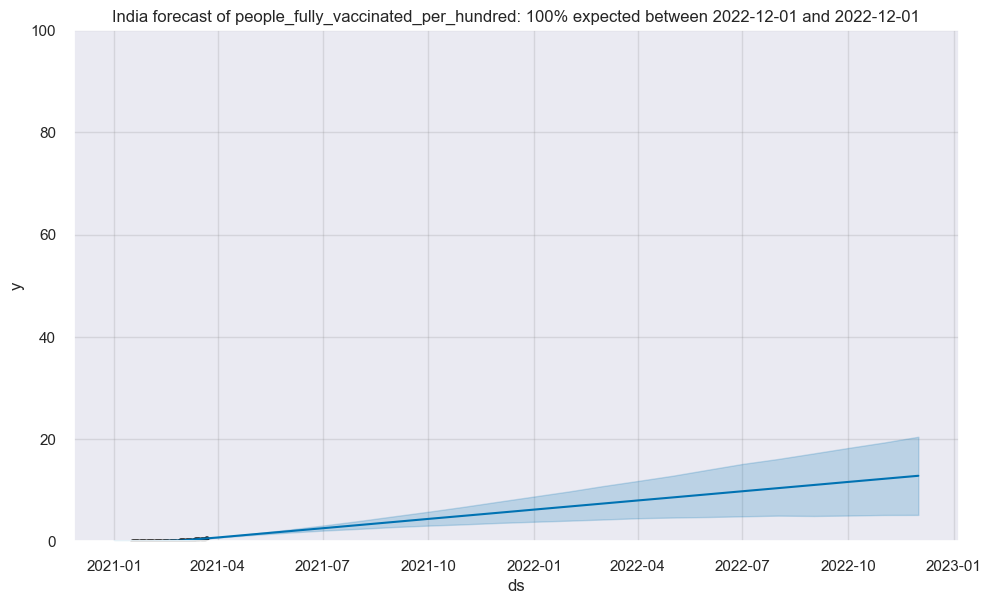

In [60]:
fcast('India')

In [61]:
df_time_m_us = df_time_m[df_time_m.country == 'United States']
df_time_m_us1 = df_time_m_us[['date','daily_vaccinations']]
#train - test - split
df_time_m_us2 = df_time_m_us1
train_test_split_ratio = int(len(df_time_m_us2)*0.8)
train_data, test_data = df_time_m_us2[:train_test_split_ratio], df_time_m_us2[train_test_split_ratio:]



In [62]:
# prepare expected column names
train_data.columns = ['ds', 'y']
train_data['ds']= pd.to_datetime(train_data['ds'])
# define the model
model = Prophet()
# fit the model
model.fit(train_data)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Make an In-Sample Forecast

forecast on historical data.

That is, we can make a forecast on data used as input to train the model. Ideally, the model has seen the data before and would make a perfect prediction.

Nevertheless, this is not the case as the model tries to generalize across all cases in the data.

This is called making an in-sample (in training set sample) forecast and reviewing the results can give insight into how good the model is. That is, how well it learned the training data.

A forecast is made by calling the predict() function and passing a DataFrame that contains one column named ‘ds‘ and rows with date-times for all the intervals to be predicted.

There are many ways to create this “forecast” DataFrame. In this case, we will loop over the month december 2020 to end of February 2021.

          ds          yhat    yhat_lower    yhat_upper
0 2021-02-01  1.281104e+06  1.140021e+06  1.412762e+06
1 2021-02-02  1.301067e+06  1.160306e+06  1.430944e+06
2 2021-02-03  1.319118e+06  1.190612e+06  1.447003e+06
3 2021-02-04  1.338828e+06  1.205484e+06  1.470318e+06
4 2021-02-05  1.342448e+06  1.218142e+06  1.476632e+06


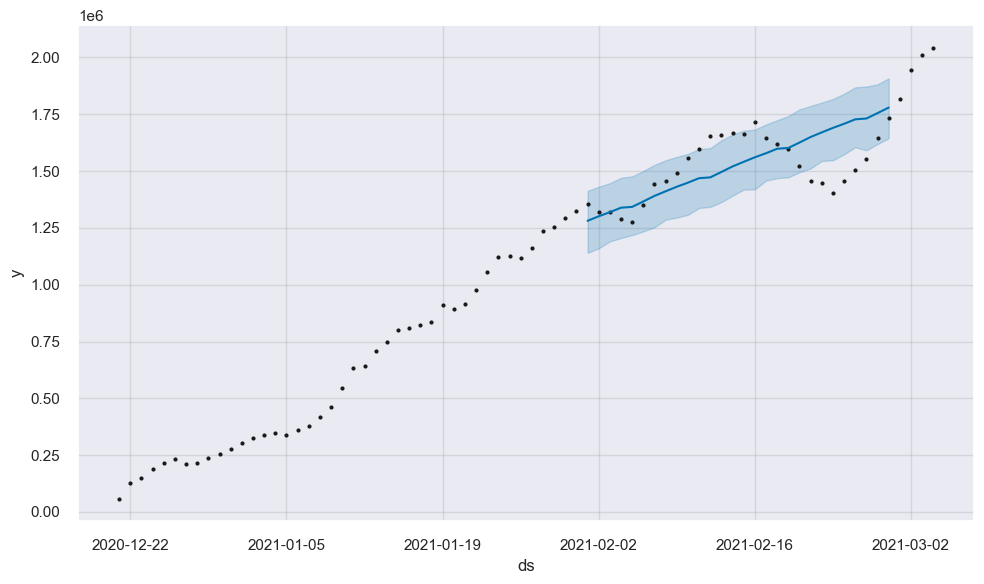

In [63]:
# define the period for which we want a prediction
future = list()
for i in range(1, 29):
    date = '2021-02-%02d' % i
    future.append([date])
future = pd.DataFrame(future)
future.columns = ['ds']
future['ds']= pd.to_datetime(future['ds'])

# use the model to make a forecast
forecast = model.predict(future)
# summarize the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
model.plot(forecast)
pyplot.show()

The training data are represented as black dots and the forecast is a blue line with upper and lower bounds in a blue shaded area.

We can see that the forecasted days are not a good match for the real observations. It is better when the bounds are taken into account but the last decrease in daily vaccinations was not met.

## Make an Out-of-Sample Forecast

 model to make a prediction beyond the training data.


           ds          yhat    yhat_lower    yhat_upper
0  2021-03-01  1.799615e+06  1.674321e+06  1.935284e+06
1  2021-03-02  1.819489e+06  1.684240e+06  1.953011e+06
2  2021-03-03  1.837452e+06  1.705619e+06  1.966405e+06
3  2021-03-04  1.857092e+06  1.724486e+06  1.982034e+06
4  2021-03-05  1.860642e+06  1.736986e+06  1.994918e+06
5  2021-03-06  1.884394e+06  1.749906e+06  2.020415e+06
6  2021-03-07  1.908794e+06  1.768027e+06  2.040778e+06
7  2021-03-08  1.929086e+06  1.799605e+06  2.064574e+06
8  2021-03-09  1.948960e+06  1.817416e+06  2.085816e+06
9  2021-03-10  1.966923e+06  1.837387e+06  2.099329e+06
10 2021-03-11  1.986563e+06  1.855944e+06  2.117908e+06
11 2021-03-12  1.990112e+06  1.863335e+06  2.122712e+06
12 2021-03-13  2.013865e+06  1.875192e+06  2.141957e+06
13 2021-03-14  2.038265e+06  1.915354e+06  2.177773e+06
14 2021-03-15  2.058557e+06  1.927888e+06  2.197199e+06
15 2021-03-16  2.078431e+06  1.949429e+06  2.211161e+06
16 2021-03-17  2.096393e+06  1.969830e+06  2.231

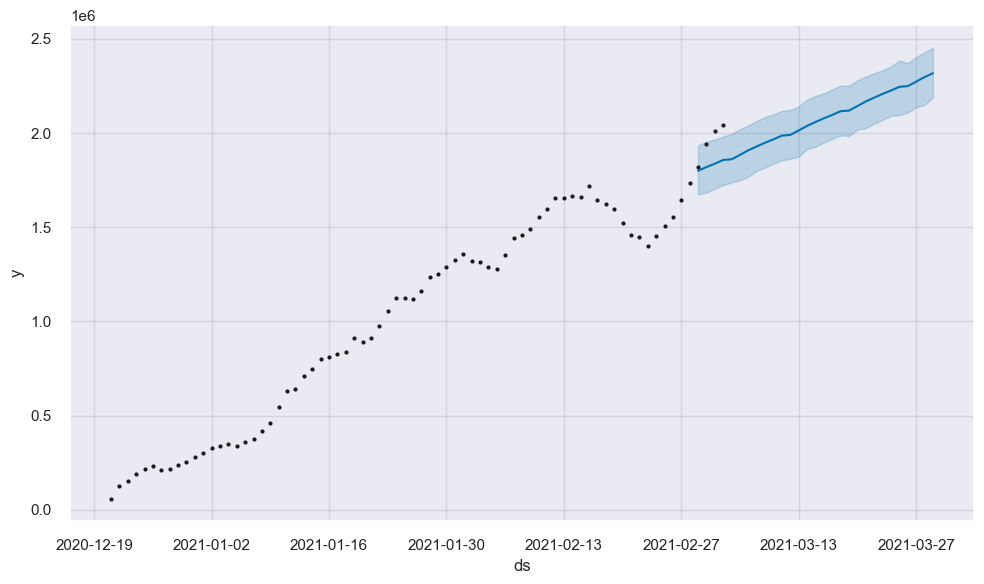

In [64]:
future = list()
for i in range(1, 30):
    date = '2021-03-%02d' % i
    future.append([date])
future = pd.DataFrame(future)
future.columns = ['ds']
future['ds']= pd.to_datetime(future['ds'])
# use the model to make a forecast
forecast = model.predict(future)
# summarize the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head(50))
# plot forecast
model.plot(forecast)
pyplot.show()

Manually Evaluate Forecast Model

In [65]:
df_time_m_us2 = df_time_m_us1
train_test_split_ratio = int(len(df_time_m_us2)*0.8)
train_data, test_data = df_time_m_us2[:train_test_split_ratio], df_time_m_us2[train_test_split_ratio:]
# prepare expected column names
train_data.columns = ['ds', 'y']
train_data['ds']= pd.to_datetime(train_data['ds'])
test_data.columns = ['ds', 'y']
test_data['ds']= pd.to_datetime(test_data['ds'])

In [66]:
test_data['y'] = test_data['y'].astype(int)
train_data['y'] = train_data['y'].astype(int)

           ds          yhat    yhat_lower    yhat_upper
0  2021-03-01  1.799615e+06  1.673825e+06  1.939967e+06
1  2021-03-02  1.819489e+06  1.684729e+06  1.955176e+06
2  2021-03-03  1.837452e+06  1.705808e+06  1.964918e+06
3  2021-03-04  1.857092e+06  1.724072e+06  1.992034e+06
4  2021-03-05  1.860642e+06  1.737790e+06  2.000760e+06
5  2021-03-06  1.884394e+06  1.749800e+06  2.021595e+06
6  2021-03-07  1.908794e+06  1.778074e+06  2.038721e+06
7  2021-03-08  1.929086e+06  1.790745e+06  2.067753e+06
8  2021-03-09  1.948960e+06  1.820030e+06  2.086234e+06
9  2021-03-10  1.966923e+06  1.840034e+06  2.097518e+06
10 2021-03-11  1.986563e+06  1.844620e+06  2.126789e+06
11 2021-03-12  1.990112e+06  1.854313e+06  2.113058e+06
12 2021-03-13  2.013865e+06  1.883857e+06  2.150232e+06
13 2021-03-14  2.038265e+06  1.909238e+06  2.162319e+06
14 2021-03-15  2.058557e+06  1.927843e+06  2.189488e+06
15 2021-03-16  2.078431e+06  1.946815e+06  2.204489e+06
16 2021-03-17  2.096393e+06  1.972278e+06  2.234

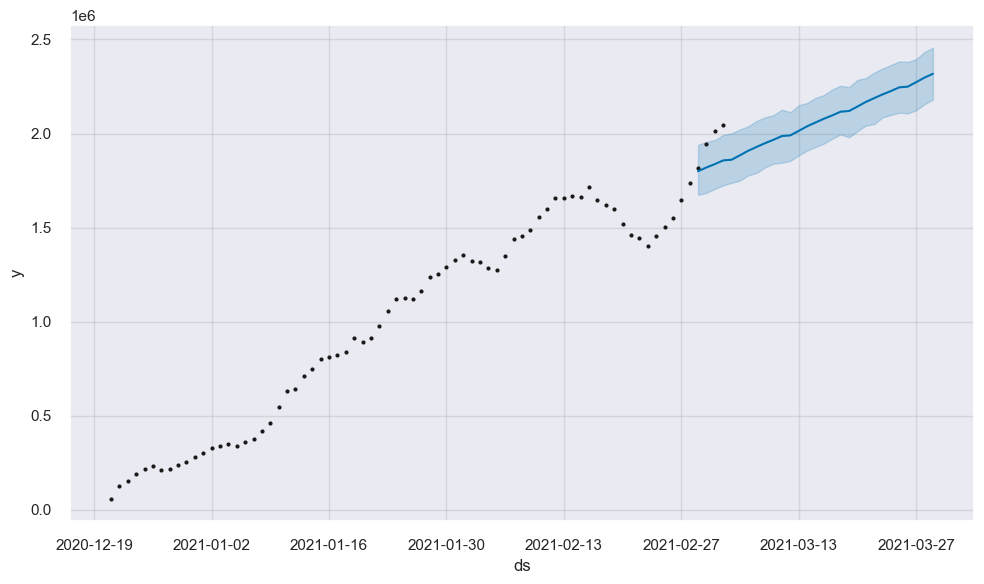

In [67]:
future = list()
for i in range(1, 30):
    date = '2021-03-%02d' % i
    future.append([date])
future = pd.DataFrame(future)
future.columns = ['ds']
future['ds']= pd.to_datetime(future['ds'])
# use the model to make a forecast
forecast = model.predict(future)
# summarize the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head(50))
# plot forecast
model.plot(forecast)
pyplot.show()

In [68]:
# create test dataset, remove last months
train = train_data.drop(train_data.index[-12:])
print(train.tail())
print(train_data.head())

             ds        y
6568 2021-02-16  1716311
6569 2021-02-17  1644551
6570 2021-02-18  1621071
6571 2021-02-19  1596355
6572 2021-02-20  1521088
             ds       y
6511 2020-12-21   57909
6512 2020-12-22  127432
6513 2020-12-23  150606
6514 2020-12-24  191001
6515 2020-12-25  215238


In [69]:
# calculate MAE between expected and predicted values for december
y_true = test_data['y'].values[-29:]#y_true = train_data['y'].values#[-1:]
y_pred = forecast['yhat'].values
mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae)

ValueError: Found input variables with inconsistent numbers of samples: [19, 29]

In [ ]:
y_true.shape

In [ ]:
y_pred.shape

In [ ]:
# plot expected vs actual
pyplot.plot(y_true, label='Actual')
pyplot.plot(y_pred, label='Predicted')
pyplot.legend()
pyplot.show()

In [ ]:
test_timestamps = []
for i in range (10):
    test_timestamps.append(pd.to_datetime(df_time_m.index[-1]) - (i+1)*pd.Timedelta(hours=24))
test_timestamps.sort()

val_timestamps = [pd.to_datetime("2020-12-13")]
for i in range (9):
    val_timestamps.append(pd.to_datetime(val_timestamps[0]) + (i+1)*pd.Timedelta(hours=24))
val_timestamps.sort()

Error Metrics Function (RMSE, R2, MAE, MAPE)

In [ ]:
def error_metrics(y_pred, y_truth, model_name = "default"):
    """
    Calculate error metrics for a single comparison between predicted and observed values
    """
    # calculating error metrics
    RMSE_return = np.sqrt(mean_squared_error(y_truth, y_pred))
    R2_return = r2_score(y_truth, y_pred)
    MAE_return = mean_absolute_error(y_truth, y_pred)
    MAPE_return = (np.mean(np.abs((y_truth - y_pred) / y_truth)) * 100)
    
    # saving error metrics in a dataframe and returning it
    name_error = ['RMSE', 'R2', 'MAE', 'MAPE']
    value_error = [RMSE_return, R2_return, MAE_return, MAPE_return/100]
    dict_error = dict()
    for i in range(len(name_error)):
        dict_error[name_error[i]] = [value_error[i]]
    errors = pd.DataFrame(dict_error).T
    errors.rename(columns={0 : model_name}, inplace = True)
    
    path = './data/error_metrics_{}.pkl'.format(model_name)
    errors.to_pickle(path)
        
    return(errors)

FB Prophet Prediction (hier auch noch mehr zu FB Prophet schreiben)

In [ ]:
def stan_init(m):
    """Retrieve parameters from a trained model.
    
    Retrieve parameters from a trained model in the format
    used to initialize a new Stan model.
    
    Parameters
    ----------
    m: A trained model of the Prophet class.
    
    Returns
    -------
    A Dictionary containing retrieved parameters of m.
    
    """
    res = {}
    for pname in ['k', 'm', 'sigma_obs']:
        res[pname] = m.params[pname][0][0]
    for pname in ['delta', 'beta']:
        res[pname] = m.params[pname][0]
    return res

In [ ]:
def rolling_prophet_model(data, tfstart, prediction_window_size_hrs = 24, train_window_size_days = 90,
                          timesteps = 18, lags = 1, logtransformation = True, target_name = "target_losses_norm"):
    """
        Predict values with a Prophet Model for a chosen timespan with a rolling-forward training window of a
        chosen size (differenced time series will be predicted).
        - data: input dataframe
        - tfstart: start timestamp of the timespan to predict for
        - prediction_window_size_hrs: size of the prediction window in hours
        - train_window_size_days: size of the training window in days
        - timesteps: number of timesteps that will be predicted ahead on each step 
        - lags: number of lags of the target_variable that should be included in the dataframe
        - logtransformation: should the target variable be transformed with the log-function for the prediction
        - target_name: column name of the target variable
        
    """
    #creating a working data frame to not change the actual input dataframe
    workframe = data.copy(deep = True)
    
    #if logtransformation is wanted
    if logtransformation == True:
        workframe[target_name] = np.log(workframe[target_name])
    
    #if lags should be included, they will be generated
    for i in range(lags):
        workframe[f"lag{i+1}"] = workframe[target_name].shift(i+1)
        
    #nan values after creation of lags will be dropped
    workframe.dropna(inplace = True)

    #creating another copy to keep the undifferenced values for backtransformation
    workframe_real = workframe.copy(deep = True)
    
    #calculating the differenced values for the target column
    workframe[target_name] = workframe[target_name].diff(1)
    
    #calculating the differenced values for the included lags
    if lags >= 1:
        for i in range(lags):
            workframe[f"lag{i+1}"] = workframe[f"lag{i+1}"].diff(1)
            
    #nan values after creation of lags will be dropped
    workframe.dropna(inplace = True)
        
    #setting start point of initial training window dependent on training window size
    train_start = pd.to_datetime(tfstart) - pd.Timedelta(days = train_window_size_days)
    
    #setting end point of test set dependent on chosen prediction window size
    tfend = pd.to_datetime(tfstart) + pd.Timedelta(hours = prediction_window_size_hrs)
    
    #making working dataframe compatible with fbprophet
    workframe.rename(columns={target_name: "y"}, inplace = True)
    
    #splitting data in train and test
    df_test = workframe[(workframe.index >= tfstart) & (workframe.index <= tfend)]    
    df_train = workframe[(workframe.index >= train_start) & (workframe.index < tfstart)]
    
    #making the copy with the undifferenced target values compatible with prophet
    workframe_real.rename(columns={target_name: "y"}, inplace = True)
    
    #creating copy of the undifferenced test data for later evalutation against predictions    
    y_test = list()
    for i in range(timesteps):
        y_test.append(workframe_real[(workframe_real.index > tfstart) & (workframe_real.index < tfend)]["y"].shift(-i).iloc[:-timesteps])
  
    #saving all the additional regressors (not the target) in list
    regressors = list(df_train.columns)
    regressors.remove("y")
    
    #adding datestamps to dataframes for compatibility with fbprophet
    df_test["ds"] = df_test.index
    df_train["ds"] = df_train.index
    
    # setting up a list to store the prediction results in
    predictions = list()

    #iterating over the test set
    for t in tqdm(range(len(df_test)-timesteps)):
            
            #initializing new Prophet model
            model = Prophet(yearly_seasonality = False)
            
            #adding all the regressors with the same hyperparameters
            for name in list(regressors):
                model.add_regressor(name, prior_scale = 1, standardize = True, mode='multiplicative')            
            
            #training the model on the current training dataframe with the saved initial parameters from the last model, if there was one
            try:
                model.fit(df_train, init = parameters);
            except NameError:
                model.fit(df_train);
            
            #saving the parameters of the fitted model for warm-start training of the next model
            parameters = stan_init(model)
            
            #the timestamp before the current prediciton timestep is calculated
            index_before = df_test.index[0] - pd.Timedelta(minutes = 10)

            #setting up future dataframe (two steps ahead) with all regressors filled in assumption of perfect forecast for regressors
            future = df_test.drop(columns = ["y"]).iloc[0:timesteps] #.to_frame().T
            
            #predicting next timestep
            forecast = model.predict(future)
            
            predictions_inner_list = list()
            
            # setting the physically possible boundaries of the predictions (must be between 0 and 1 after backtransformation) depending on the chosen transformations
            for i in range(timesteps):
                if (logtransformation == True):
                    if forecast["yhat"].iloc[0:i].sum() + workframe_real.loc[index_before]["y"] < -30:
                         predictions_inner_list.append(-30)
                    elif forecast["yhat"].iloc[0:i].sum() + workframe_real.loc[index_before]["y"] >= 0:
                         predictions_inner_list.append(0)
                    else:
                         predictions_inner_list.append(forecast["yhat"].iloc[0:i].sum() + workframe_real.loc[index_before]["y"])
                            
                else:
                    if forecast["yhat"].iloc[0:i].sum() + workframe_real.loc[index_before]["y"] < 0:
                        predictions_inner_list.append(0)
                    elif forecast["yhat"].iloc[0:i].sum() + workframe_real.loc[index_before]["y"] >= 1:
                        predictions_inner_list.append(1)
                    else:
                        predictions_inner_list.append(forecast["yhat"].iloc[0:i].sum() + workframe_real.loc[index_before]["y"])
                    
            predictions.append(predictions_inner_list)
                                         
            #dropping the left end point of the training dataframe            
            df_train.drop(df_train.index[0], inplace = True)
            
            #appending the left end point of the test dataframe to the training dataframe
            df_train = df_train.append(df_test.iloc[0].to_frame().T)
            
            #dropping the left end point of the test dataframe
            df_test.drop(df_test.index[0], inplace = True)
            
    columnnames = list()
    testcolumnnames = list()
    
    for i in range(timesteps):
        columnnames.append(f"y_pred{i+1}")
        testcolumnnames.append(f"y_test{i+1}")

    results = pd.DataFrame(columns = columnnames)
    original = pd.DataFrame(columns = testcolumnnames)
    
    for i in range(timesteps):
        results[f"y_pred{i+1}"] = pd.Series(v for v in [el[i] for el in predictions])
        original[f"y_test{i+1}"] = y_test[i]
        

    #setting the indices as they were 
    results.index = y_test[0].index
    
    #backtransformation to real values if logtransformation was used
    if logtransformation == True:
        results = np.exp(results)
        original = np.exp(original)
         
    ##creating the dataframe that will be saved as a file
    #results.to_csv(f".data/{filename}_predictions.csv")
    #original.to_csv(f".data/{filename}_test.csv")
    #print(f"Predictions and test values saved.")
    
    #returning the dataframes with the results
    return results, original

Tuning Prophet Model on Validation Data

In [ ]:
y_pred, y_test = rolling_prophet_model(data = df_time_m, tfstart = val_timestamps[0], prediction_window_size_hrs = 240, train_window_size_days = 60, timesteps = 18, lags = 2, logtransformation = True, target_name = "people_fully_vaccinated_per_hundred")

In [ ]:
columnnames = list()
for i in range(18):
    columnnames.append(f"FB Prophet Prediction Step {i+1}")
    
val_errors = pd.DataFrame(columns = columnnames)

for i in range(18):
    val_errors[f"FB Prophet Prediction Step {i+1}"]  = error_metrics(y_pred[f"y_pred{i+1}"],y_test[f"y_test{i+1}"])["default"]
    
val_errors = val_errors.T